In [2]:
import pandas as pd
import numpy as np

# Load data
data = pd.read_csv('K27M.csv')

# Set 'Gene' as the index
data.set_index('Gene', inplace=True)

# Log normalize the data
data = np.log1p(data)

# Remove NAs
data.dropna(inplace=True)

# Save the preprocessed data to a new CSV file
data.to_csv('K27M_log_normalized.csv')

print("Data log normalization and preprocessing completed.")


Data log normalization and preprocessing completed.


In [5]:
import pandas as pd
import numpy as np

# Load data
data = pd.read_csv('IDHWT.csv')

# Set 'Gene' as the index
data.set_index('GENE', inplace=True)

# Log normalize the data
data = np.log1p(data)

# Remove NAs
data.dropna(inplace=True)

# Save the preprocessed data to a new CSV file
data.to_csv('IDHWT_log_normalized.csv')

print("Data log normalization and preprocessing completed for IDHWT.csv.")


Data log normalization and preprocessing completed for IDHWT.csv.


In [ ]:
#Repeat on K27M_log_normalized.csv and IDHWT_log_normalized.csv
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('IDHWT_log_normalized.csv')

# Set 'Gene' as the index
data.set_index('Gene', inplace=True)

# Log normalize the data
data = np.log1p(data)

# Remove NAs
data.dropna(inplace=True)

# Convert to numpy array
features = data.values.T  # Transpose the features to match cells

# Standardize the data
scaler = StandardScaler()
features = scaler.fit_transform(features)

# VAE model definition
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc2_mu(h1), self.fc2_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function for VAE
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Initialize model, optimizer, and loss function
input_dim = features.shape[1]
hidden_dim = 128
latent_dim = 32
model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
features_tensor = torch.tensor(features, dtype=torch.float32)
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    recon_batch, mu, logvar = model(features_tensor)
    loss = loss_function(recon_batch, features_tensor, mu, logvar)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Extract latent space representation
model.eval()
with torch.no_grad():
    _, mu, _ = model(features_tensor)
    latent_features = mu.numpy()

# Clustering in latent space
n_clusters = 3  # Adjust as necessary
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(latent_features)

# Save cluster assignments
cluster_assignments = pd.DataFrame(clusters, index=data.columns, columns=['Cluster'])
os.makedirs('VAE/results', exist_ok=True)
cluster_assignments.to_csv('VAE/results/predicted_clusters.csv')

# Identify transition genes between clusters using Mann-Whitney U test
transition_genes = []
for cluster in range(n_clusters):
    cluster_genes = features[clusters == cluster]
    other_genes = features[clusters != cluster]
    for i in range(features.shape[1]):
        stat, p_value = mannwhitneyu(cluster_genes[:, i], other_genes[:, i])
        if p_value < 0.05:  # Adjust threshold as necessary
            transition_genes.append((data.index[i], p_value, np.log(np.mean(cluster_genes[:, i]) / np.mean(other_genes[:, i]))))

# Save transition genes
transition_genes_df = pd.DataFrame(transition_genes, columns=['Gene', 'p-value', 'logFC'])
transition_genes_df.to_csv('VAE/results/transition_genes.csv', index=False)

# Plot latent space representation
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_features)
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Latent Space Representation')
plt.savefig('VAE/results/latent_space.png')
plt.show()

print("Clustering and transition gene analysis completed.")

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Create a RandomForest model and fit it to the latent space and clusters
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(latent_features, clusters)

# Get feature importances from the RandomForest model
feature_importances = rf_model.feature_importances_

# Identify the top 30 most important genes for each cluster
important_genes = []
for cluster in range(n_clusters):
    cluster_genes = features[clusters == cluster]
    other_genes = features[clusters != cluster]

    # Train a RandomForest model to distinguish this cluster from others
    y = np.concatenate([np.ones(cluster_genes.shape[0]), np.zeros(other_genes.shape[0])])
    X = np.concatenate([cluster_genes, other_genes])

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    # Get the top 30 most important genes for this cluster
    importances = rf.feature_importances_
    indices = np.argsort(importances)[-30:]
    important_genes.append(data.index[indices].tolist())

# Save the important genes for each cluster as CSV
os.makedirs('VAE/results/important_genes', exist_ok=True)
for cluster in range(n_clusters):
    cluster_genes_df = pd.DataFrame(important_genes[cluster], columns=['Gene'])
    cluster_genes_df.to_csv(f'VAE/results/important_genes/cluster_{cluster}_important_genes.csv', index=False)

print("Important genes for each cluster saved.")

# Identify the top 30 DEGs for each cluster using the RandomForest model
top_degs = []
for cluster in range(n_clusters):
    cluster_genes = features[clusters == cluster]
    other_genes = features[clusters != cluster]

    # Train a RandomForest model to distinguish this cluster from others
    y = np.concatenate([np.ones(cluster_genes.shape[0]), np.zeros(other_genes.shape[0])])
    X = np.concatenate([cluster_genes, other_genes])

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    # Get the top 30 DEGs for this cluster
    importances = rf.feature_importances_
    indices = np.argsort(importances)[-30:]
    top_degs.append(data.index[indices].tolist())

# Save the top 30 DEGs for each cluster as CSV
os.makedirs('VAE/results/top_degs', exist_ok=True)
for cluster in range(n_clusters):
    degs_df = pd.DataFrame(top_degs[cluster], columns=['Gene'])
    degs_df.to_csv(f'VAE/results/top_degs/cluster_{cluster}_top_degs.csv', index=False)

print("Top 30 DEGs for each cluster saved.")


Important genes for each cluster saved.
Top 30 DEGs for each cluster saved.


In [3]:
#scGAN

import os
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score as ARI

# Define VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, n_latent, n_hidden, n_layers, n_batch):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim + n_batch, n_hidden)
        self.fc21 = nn.Linear(n_hidden, n_latent)
        self.fc22 = nn.Linear(n_hidden, n_latent)
        self.fc3 = nn.Linear(n_latent + n_batch, n_hidden)
        self.fc4 = nn.Linear(n_hidden, input_dim)
    
    def encode(self, x, b):
        b_expanded = b.unsqueeze(1).expand(-1, x.size(1))  # Ensure b has the same number of features as x
        h1 = F.relu(self.fc1(torch.cat((x, b_expanded), dim=1)))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, b):
        b_expanded = b.unsqueeze(1).expand(-1, z.size(1))  # Ensure b has the same number of features as z
        h3 = F.relu(self.fc3(torch.cat((z, b_expanded), dim=1)))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x, b):
        mu, logvar = self.encode(x, b)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, b), mu, logvar

# Define Discriminator model
class Discriminator(nn.Module):
    def __init__(self, n_latent, n_hidden, n_output):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(n_latent, n_hidden[0])
        self.fc2 = nn.Linear(n_hidden[0], n_hidden[1])
        self.fc3 = nn.Linear(n_hidden[1], n_output)
    
    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return F.log_softmax(self.fc3(h2), dim=1)

# Define GANTrainer class
class GANTrainer:
    def __init__(self, vae, disc, dataset, device, batch_size):
        self.vae = vae
        self.disc = disc
        self.dataset = dataset
        self.device = device
        self.batch_size = batch_size
    
    def train(self, n_epochs, lr, eps, disc_lr, enc_lr):
        optimizer_vae = optim.Adam(self.vae.parameters(), lr=lr, eps=eps)
        optimizer_disc = optim.Adam(self.disc.parameters(), lr=disc_lr, eps=eps)
        train_loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True)
        history = []
        
        for epoch in range(n_epochs):
            self.vae.train()
            self.disc.train()
            vae_losses = []
            disc_losses = []
            
            for x, labels, batches in train_loader:
                x = x.to(self.device)
                labels = labels.to(self.device)
                batches = batches.to(self.device)
                
                # VAE step
                optimizer_vae.zero_grad()
                recon_x, mu, logvar = self.vae(x, batches)
                recon_loss = F.mse_loss(recon_x, x, reduction='sum')
                kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                vae_loss = recon_loss + kld
                vae_loss.backward()
                optimizer_vae.step()
                vae_losses.append(vae_loss.item())
                
                # Discriminator step
                optimizer_disc.zero_grad()
                z = self.vae.reparameterize(mu, logvar)
                disc_loss = F.nll_loss(self.disc(z.detach()), batches)
                disc_loss.backward()
                optimizer_disc.step()
                disc_losses.append(disc_loss.item())
            
            vae_loss_avg = np.mean(vae_losses)
            disc_loss_avg = np.mean(disc_losses)
            history.append((vae_loss_avg, disc_loss_avg))
            
            if epoch % 10 == 0:
                print(f'Epoch {epoch}, VAE Loss: {vae_loss_avg}, Disc Loss: {disc_loss_avg}')
        
        return history
    
    def get_latent(self):
        self.vae.eval()
        self.disc.eval()
        all_latent = []
        all_labels = []
        all_batches = []
        
        train_loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=False)
        with torch.no_grad():
            for x, labels, batches in train_loader:
                x = x.to(self.device)
                batches = batches.to(self.device)
                mu, logvar = self.vae.encode(x, batches)
                z = self.vae.reparameterize(mu, logvar)
                all_latent.append(z)
                all_labels.append(labels)
                all_batches.append(batches)
        
        latent = torch.cat(all_latent, dim=0)
        labels = torch.cat(all_labels, dim=0)
        batches = torch.cat(all_batches, dim=0)
        return latent, labels, batches

# Define GeneDataset class
class GeneDataset(Dataset):
    def __init__(self, data, labels, batches):
        self.data = torch.tensor(data.toarray(), dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long).clone().detach()
        self.batches = torch.tensor(batches, dtype=torch.long).clone().detach()
        self.nb_genes = self.data.shape[1]
        self.n_batches = len(torch.unique(self.batches))  # Ensure the batches tensor is used here
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index], self.batches[index]


In [6]:
# Load and preprocess gene expression data
data = pd.read_csv("K27M.csv")
data = data[~data['Gene'].duplicated()]  # Remove duplicate gene names
data.set_index('Gene', inplace=True)

# Log normalize the data
data = np.log1p(data.T)

# Convert to AnnData
adata = sc.AnnData(data)
adata.var_names_make_unique()

In [7]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

In [15]:
adata

AnnData object with n_obs × n_vars = 1943 × 23658
    obs: 'labels', 'batch'

In [16]:
# Create AnnData object
adata = sc.AnnData(data)

# Create batch labels for scGAN using row indices
adata.obs['labels'] = pd.Categorical(adata.obs.index).codes
adata.obs['batch'] = pd.Categorical(
    adata.obs.index.to_series().str.extract(r'(\d+)')[0].fillna(-1).astype(int) // 10
).codes


In [17]:
# Create GeneDataset (adjust according to your dataset class implementation)
class GeneDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, batches):
        self.data = torch.tensor(data, dtype=torch.float32).clone().detach()
        self.labels = torch.tensor(labels, dtype=torch.long).clone().detach()
        self.batches = torch.tensor(batches, dtype=torch.long).clone().detach()
        self.nb_genes = self.data.shape[1]
        self.n_batches = len(torch.unique(self.batches))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], self.batches[idx]

# Instantiate GeneDataset
dataset = GeneDataset(adata.X, adata.obs['labels'], adata.obs['batch'])

In [18]:
# Define the VAE class without n_layers parameter
class VAE(torch.nn.Module):
    def __init__(self, input_dim, n_latent, n_hidden, n_batch):
        super(VAE, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim + 1, n_hidden)  # Adding 1 for the batch feature
        self.fc21 = torch.nn.Linear(n_hidden, n_latent)
        self.fc22 = torch.nn.Linear(n_hidden, n_latent)
        self.fc3 = torch.nn.Linear(n_latent + 1, n_hidden)  # Adding 1 for the batch feature
        self.fc4 = torch.nn.Linear(n_hidden, input_dim)

    def encode(self, x, b):
        b_expanded = b.unsqueeze(1)  # Ensure b has the same number of samples as x
        x_cat = torch.cat((x, b_expanded), dim=1)
        h1 = F.relu(self.fc1(x_cat))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, b):
        b_expanded = b.unsqueeze(1)
        z_cat = torch.cat((z, b_expanded), dim=1)
        h3 = F.relu(self.fc3(z_cat))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x, b):
        mu, logvar = self.encode(x, b)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, b), mu, logvar

# Define the Discriminator class
class Discriminator(torch.nn.Module):
    def __init__(self, n_latent, hidden_layers, n_classes):
        super(Discriminator, self).__init__()
        layers = []
        input_dim = n_latent
        for hidden_dim in hidden_layers:
            layers.append(torch.nn.Linear(input_dim, hidden_dim))
            layers.append(torch.nn.ReLU())
            input_dim = hidden_dim
        layers.append(torch.nn.Linear(input_dim, n_classes))
        self.model = torch.nn.Sequential(*layers)

    def forward(self, z, b):
        b_expanded = b.unsqueeze(1)
        z_cat = torch.cat((z, b_expanded), dim=1)
        return self.model(z_cat)

# Initialize VAE and Discriminator
n_epochs = 30
lr = 0.001
eps = 1e-8
n_latent = 10
batch_size = 128
device = 'cpu'

vae = VAE(dataset.nb_genes, n_latent=n_latent, n_hidden=64, n_batch=dataset.n_batches).to(device)
disc = Discriminator(n_latent, [2 * n_latent, 2 * n_latent], dataset.n_batches).to(device)
trainer = GANTrainer(vae, disc, dataset, device, batch_size)


In [19]:
class GeneDataset:
    def __init__(self, data, labels, batches):
        self.data = torch.tensor(data, dtype=torch.float32).clone().detach()
        self.labels = torch.tensor(labels, dtype=torch.long).clone().detach()
        self.batches = torch.tensor(batches.values, dtype=torch.long).clone().detach()  # Convert Series to Tensor
        self.nb_genes = self.data.shape[1]
        self.n_batches = len(torch.unique(self.batches))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.batches[idx], self.labels[idx]

# Create GeneDataset instance
dataset = GeneDataset(adata.X, adata.obs['labels'], adata.obs['batch'])


In [20]:
class Discriminator(nn.Module):
    def __init__(self, n_latent, hidden_dims, n_batches):
        super(Discriminator, self).__init__()
        layers = []
        input_dim = n_latent + 1  # Adding 1 to account for the batch information
        for h_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, h_dim))
            layers.append(nn.ReLU())
            input_dim = h_dim
        layers.append(nn.Linear(input_dim, n_batches))
        self.model = nn.Sequential(*layers)

    def forward(self, z_cat):
        return self.model(z_cat)

# Initialize VAE and Discriminator
vae = VAE(dataset.nb_genes, n_latent=n_latent, n_hidden=64, n_batch=dataset.n_batches).to(device)
disc = Discriminator(n_latent, [2 * n_latent, 2 * n_latent], dataset.n_batches).to(device)
trainer = GANTrainer(vae, disc, dataset, device, batch_size)


In [24]:
plt.plot(x, elbo_train)
plt.xlabel('Epochs')
plt.ylabel('VAE Loss')
plt.title('VAE Training Loss')
plt.savefig('scGAN/pretraining_loss.png')
plt.show()


NameError: name 'x' is not defined

In [27]:
class GANTrainer:
    def __init__(self, vae, disc, dataset, device, batch_size):
        self.vae = vae
        self.disc = disc
        self.dataset = dataset
        self.device = device
        self.batch_size = batch_size

    def train(self, n_epochs, lr, eps, disc_lr, enc_lr):
        optimizer_vae = torch.optim.Adam(self.vae.parameters(), lr=lr, eps=eps)
        optimizer_disc = torch.optim.Adam(self.disc.parameters(), lr=disc_lr, eps=eps)
        history = []

        for epoch in range(n_epochs):
            indices = np.arange(len(self.dataset))
            np.random.shuffle(indices)
            num_batches = len(indices) // self.batch_size

            vae_loss_epoch = 0.0

            for batch_idx in range(num_batches):
                batch_indices = indices[batch_idx * self.batch_size: (batch_idx + 1) * self.batch_size]
                batch_data, batch_batches, _ = self.dataset[batch_indices]

                x = batch_data.to(self.device).clone().detach().requires_grad_(True)
                batches = batch_batches.to(self.device).clone().detach()

                # VAE step
                optimizer_vae.zero_grad()
                recon_x, mu, logvar = self.vae(x, batches)
                recon_loss = F.mse_loss(recon_x, x, reduction='sum')
                kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                vae_loss = recon_loss + kld
                vae_loss.backward(retain_graph=True)  # Retain graph for the discriminator step
                optimizer_vae.step()

                vae_loss_epoch += vae_loss.item()

                # Discriminator step
                optimizer_disc.zero_grad()
                z = self.vae.reparameterize(mu, logvar).clone().detach().requires_grad_(True)
                b_expanded = batches.unsqueeze(1).clone().detach()
                z_cat = torch.cat((z, b_expanded), dim=1)
                disc_pred = self.disc(z_cat)
                disc_loss = F.cross_entropy(disc_pred, batches.long())
                disc_loss.backward()
                optimizer_disc.step()

            history.append(vae_loss_epoch / num_batches)
            print(f'Epoch {epoch}, VAE Loss: {vae_loss_epoch / num_batches}')

        return history

    def get_latent(self):
        self.vae.eval()
        latent = []
        labels = []
        batches = []
        with torch.no_grad():
            for i in range(0, len(self.dataset), self.batch_size):
                batch_data, batch_labels, batch_batches = self.dataset[i:i+self.batch_size]

                x = batch_data.to(self.device)
                batches_t = batch_batches.to(self.device)
                
                mu, logvar = self.vae.encode(x, batches_t)
                z = self.vae.reparameterize(mu, logvar)
                latent.append(z)
                labels.append(batch_labels)
                batches.append(batch_batches)
                
        return torch.cat(latent), torch.cat(labels), torch.cat(batches)


In [29]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

class GANTrainer:
    def __init__(self, vae, disc, dataset, device, batch_size):
        self.vae = vae
        self.disc = disc
        self.dataset = dataset
        self.device = device
        self.batch_size = batch_size

    def train(self, n_epochs, lr, eps, disc_lr, enc_lr):
        optimizer_vae = torch.optim.Adam(self.vae.parameters(), lr=lr, eps=eps)
        optimizer_disc = torch.optim.Adam(self.disc.parameters(), lr=disc_lr, eps=eps)
        history = []

        for epoch in range(n_epochs):
            indices = np.arange(len(self.dataset))
            np.random.shuffle(indices)
            num_batches = len(indices) // self.batch_size

            vae_loss_epoch = 0.0

            for batch_idx in range(num_batches):
                batch_indices = indices[batch_idx * self.batch_size: (batch_idx + 1) * self.batch_size]
                batch_data, batch_batches, _ = self.dataset[batch_indices]

                x = batch_data.to(self.device).clone().detach().requires_grad_(True)
                batches = batch_batches.to(self.device).clone().detach()

                # VAE step
                optimizer_vae.zero_grad()
                recon_x, mu, logvar = self.vae(x, batches)
                recon_loss = F.mse_loss(recon_x, x, reduction='sum')
                kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                vae_loss = recon_loss + kld
                vae_loss.backward(retain_graph=True)  # Retain graph for the discriminator step
                optimizer_vae.step()

                vae_loss_epoch += vae_loss.item()

                # Discriminator step
                optimizer_disc.zero_grad()
                z = self.vae.reparameterize(mu, logvar).clone().detach().requires_grad_(True)
                b_expanded = batches.unsqueeze(1).clone().detach()
                z_cat = torch.cat((z, b_expanded), dim=1)
                disc_pred = self.disc(z_cat)
                disc_loss = F.cross_entropy(disc_pred, batches.long())
                disc_loss.backward()
                optimizer_disc.step()

            history.append(vae_loss_epoch / num_batches)
            print(f'Epoch {epoch}, VAE Loss: {vae_loss_epoch / num_batches}')

        return history

    def get_latent(self):
        self.vae.eval()
        latent = []
        labels = []
        batches = []
        with torch.no_grad():
            for i in range(0, len(self.dataset), self.batch_size):
                batch_data, batch_labels, batch_batches = self.dataset[i:i+self.batch_size]

                x = batch_data.to(self.device)
                batches_t = batch_batches.to(self.device)
                
                mu, logvar = self.vae.encode(x, batches_t)
                z = self.vae.reparameterize(mu, logvar)
                latent.append(z)
                labels.append(batch_labels)
                batches.append(batch_batches)
                
        return torch.cat(latent), torch.cat(labels), torch.cat(batches)


Epoch 0, VAE Loss: 1025609.575
Epoch 1, VAE Loss: 728236.4458333333
Epoch 2, VAE Loss: 613378.7958333333
Epoch 3, VAE Loss: 593370.6666666666
Epoch 4, VAE Loss: 583906.1208333333
Epoch 5, VAE Loss: 576006.3791666667
Epoch 6, VAE Loss: 569259.0375
Epoch 7, VAE Loss: 563293.3125
Epoch 8, VAE Loss: 558489.3458333333
Epoch 9, VAE Loss: 553312.4625
Epoch 10, VAE Loss: 548769.8833333333
Epoch 11, VAE Loss: 545547.4916666667
Epoch 12, VAE Loss: 542376.9708333333
Epoch 13, VAE Loss: 540183.3708333333
Epoch 14, VAE Loss: 538409.2083333334
Epoch 15, VAE Loss: 536392.8875
Epoch 16, VAE Loss: 534585.1833333333
Epoch 17, VAE Loss: 532889.0666666667
Epoch 18, VAE Loss: 531028.8479166667
Epoch 19, VAE Loss: 530079.2708333334
Epoch 20, VAE Loss: 529050.0104166666
Epoch 21, VAE Loss: 527644.1854166667
Epoch 22, VAE Loss: 526694.4458333333
Epoch 23, VAE Loss: 525855.8291666667
Epoch 24, VAE Loss: 524776.8916666667
Epoch 25, VAE Loss: 524146.55833333335
Epoch 26, VAE Loss: 523443.59791666665
Epoch 27, VA

FileNotFoundError: [Errno 2] No such file or directory: 'scGAN/pretraining_loss.png'

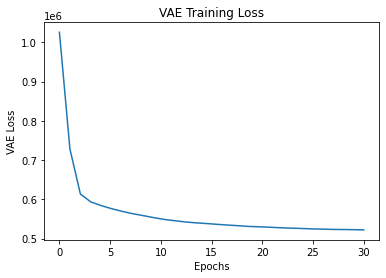

In [30]:
# Initialize the GANTrainer and train the model
n_epochs = 30
lr = 0.001
eps = 1e-8
n_latent = 10
batch_size = 128
device = 'cpu'

vae = VAE(dataset.nb_genes, n_latent=n_latent, n_hidden=64, n_batch=dataset.n_batches).to(device)
disc = Discriminator(n_latent, [2 * n_latent, 2 * n_latent], dataset.n_batches).to(device)
trainer = GANTrainer(vae, disc, dataset, device, batch_size)

# Pretraining
history = trainer.train(n_epochs=n_epochs, lr=lr, eps=eps, disc_lr=lr * 0.0, enc_lr=lr * 0.0)
elbo_train = [h for h in history]
x = np.linspace(0, len(elbo_train), len(elbo_train))
plt.plot(x, elbo_train)
plt.xlabel('Epochs')
plt.ylabel('VAE Loss')
plt.title('VAE Training Loss')
plt.savefig('scGAN/pretraining_loss.png')
plt.show()

# Extract latent representations
latent, labels, batches = [item.detach().cpu().numpy() for item in trainer.get_latent()]
adata.obsm["X_scGAN"] = latent


Epoch 0, VAE Loss: 539805.36875
Epoch 1, VAE Loss: 524555.7020833333
Epoch 2, VAE Loss: 521613.6770833333
Epoch 3, VAE Loss: 520722.5
Epoch 4, VAE Loss: 520036.07708333334
Epoch 5, VAE Loss: 519816.63333333336
Epoch 6, VAE Loss: 519563.925
Epoch 7, VAE Loss: 518912.62083333335
Epoch 8, VAE Loss: 518559.13958333334
Epoch 9, VAE Loss: 518139.14375
Epoch 10, VAE Loss: 517736.9083333333
Epoch 11, VAE Loss: 517494.8729166667
Epoch 12, VAE Loss: 517038.0104166667
Epoch 13, VAE Loss: 516861.2291666667
Epoch 14, VAE Loss: 516474.13958333334
Epoch 15, VAE Loss: 515863.43333333335
Epoch 16, VAE Loss: 515528.88125
Epoch 17, VAE Loss: 515264.24375
Epoch 18, VAE Loss: 515151.2791666667
Epoch 19, VAE Loss: 514870.43333333335
Epoch 20, VAE Loss: 514778.41875
Epoch 21, VAE Loss: 514250.57708333334
Epoch 22, VAE Loss: 514214.90208333335
Epoch 23, VAE Loss: 513885.375
Epoch 24, VAE Loss: 514033.1854166667
Epoch 25, VAE Loss: 513404.4666666667
Epoch 26, VAE Loss: 513104.4625
Epoch 27, VAE Loss: 512933.70

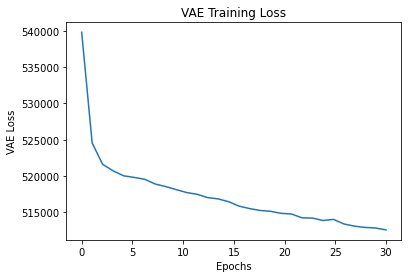

In [32]:
# Pretraining
history = trainer.train(n_epochs=n_epochs, lr=lr, eps=eps, disc_lr=lr * 0.0, enc_lr=lr * 0.0)
elbo_train = [h for h in history]
x = np.linspace(0, len(elbo_train), len(elbo_train))
plt.plot(x, elbo_train)
plt.xlabel('Epochs')
plt.ylabel('VAE Loss')
plt.title('VAE Training Loss')
plt.savefig('pretraining_loss.png')
plt.show()

# Extract latent representations
latent, labels, batches = [item.detach().cpu().numpy() for item in trainer.get_latent()]
adata.obsm["X_scGAN"] = latent

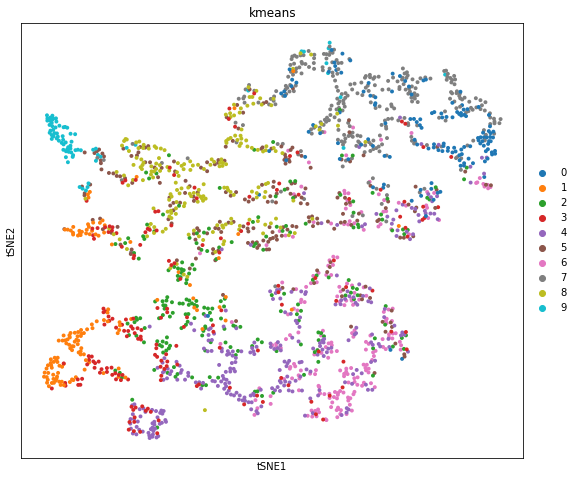

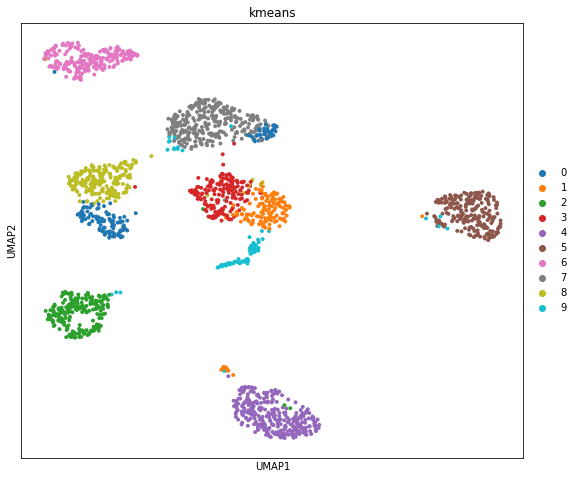

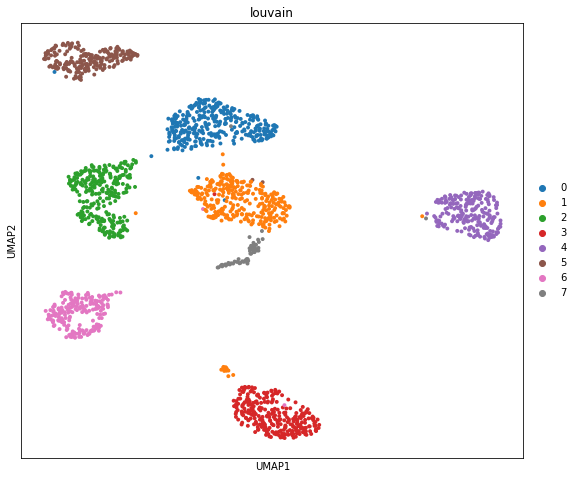

Louvain Clustering ARI: 0.8943436652787708


In [33]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.cluster import KMeans  # Import KMeans for clustering

# Perform KMeans clustering on latent space
kmeans = KMeans(n_clusters=10, random_state=42).fit(latent)
adata.obs['kmeans'] = kmeans.labels_.astype(str)

# Visualization: t-SNE and UMAP
# t-SNE Visualization
sc.tl.tsne(adata, use_rep='X_scGAN', n_pcs=2)
fig, ax = plt.subplots(figsize=(9, 8))
sc.pl.tsne(adata, color=["kmeans"], ax=ax, show=False)
plt.savefig('scGAN/tsne_kmeans.png')
plt.show()

# UMAP Visualization
sc.pp.neighbors(adata, use_rep="X_scGAN", n_neighbors=30)
sc.tl.umap(adata)
fig, ax = plt.subplots(figsize=(9, 8))
sc.pl.umap(adata, color=["kmeans"], ax=ax, show=False)
plt.savefig('scGAN/umap_kmeans.png')
plt.show()

# Clustering and Analysis
# Clustering and scoring
sc.pp.neighbors(adata, use_rep="X_scGAN", n_neighbors=30)
sc.tl.louvain(adata, resolution=0.5)
fig, ax = plt.subplots(figsize=(9, 8))
sc.pl.umap(adata, color=['louvain'], ax=ax, show=False)
plt.savefig('scGAN/umap_louvain.png')
plt.show()

from sklearn.metrics import adjusted_rand_score as ARI
ari_score = ARI(labels, adata.obs['louvain'])
print(f"Louvain Clustering ARI: {ari_score}")

# Save clustering results
adata.obs.to_csv('scGAN/clustering_results.csv')

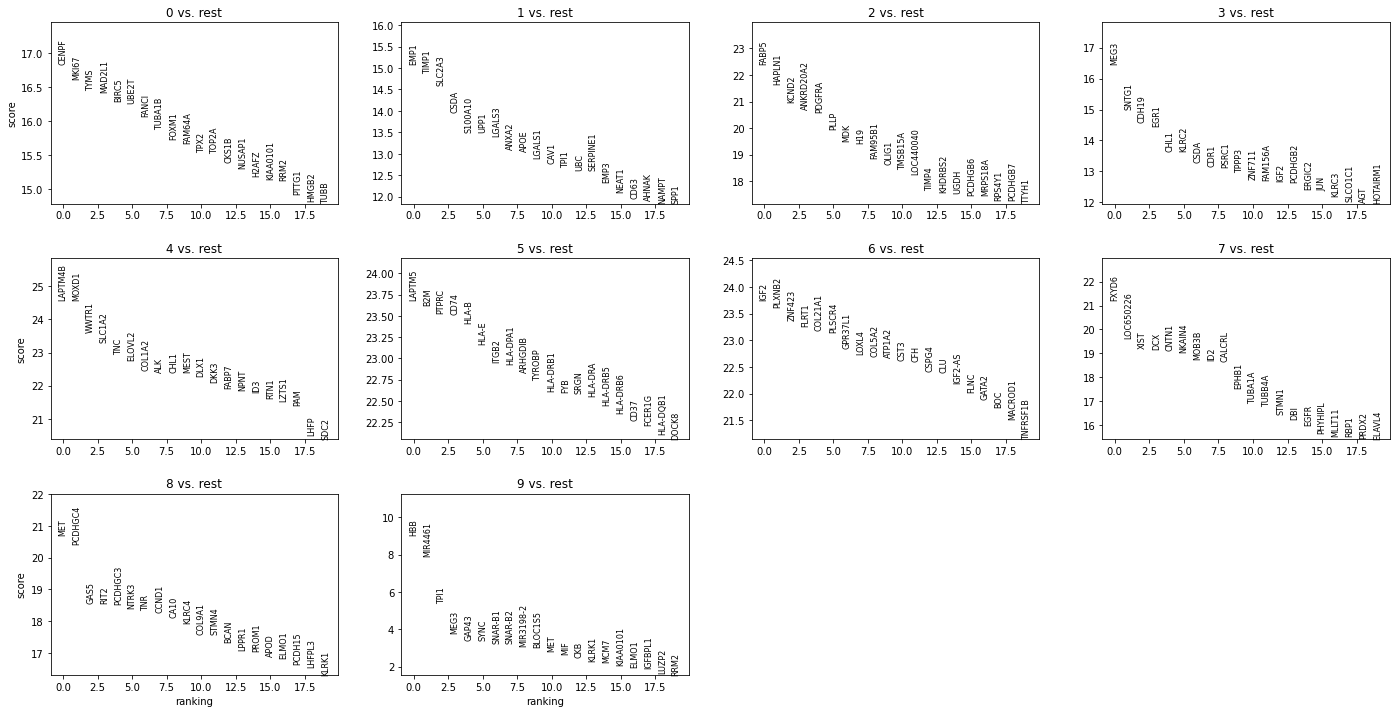

<Figure size 432x288 with 0 Axes>

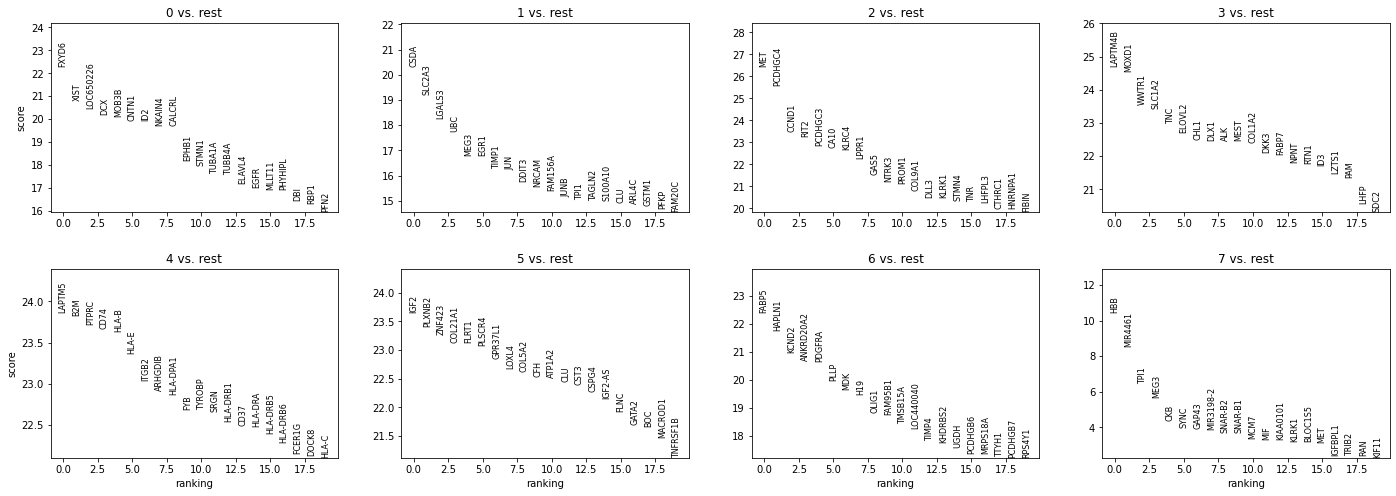

<Figure size 432x288 with 0 Axes>

In [34]:
import scanpy as sc

# Function to identify significant genes
def identify_significant_genes(adata, cluster_key):
    sc.tl.rank_genes_groups(adata, groupby=cluster_key, method='wilcoxon')
    significant_genes = sc.get.rank_genes_groups_df(adata, group=None)
    return significant_genes

# Identifying significant genes for KMeans clusters
significant_genes_kmeans = identify_significant_genes(adata, 'kmeans')
significant_genes_kmeans.to_csv('scGAN/significant_genes_kmeans.csv')

# Plot top significant genes for KMeans clusters
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)
plt.savefig('scGAN/top_significant_genes_kmeans.png')
plt.show()

# Identifying Significant Genes for Louvain Clusters

# Identifying significant genes for Louvain clusters
significant_genes_louvain = identify_significant_genes(adata, 'louvain')
significant_genes_louvain.to_csv('scGAN/significant_genes_louvain.csv')

# Plot top significant genes for Louvain clusters
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)
plt.savefig('scGAN/top_significant_genes_louvain.png')
plt.show()
